# Task 2

The second task of the OpenClassrooms project is generating the dataset needed for the models.

The dataset to be produced will be based on the World Income Distribution, but it will be 500 times bigger. Based on the WID and the Worldbank Data, we already have the following information:

* \(c_{i,parent}\)

* \(m_{j} \) : the average income in country \(j\)

* \(G_{j}\) : Gini index of country \(j\)

The individual parent’s income class is still missing  \(c_{i,parent}\) and it needs to be generated

The dataset for finding the elasticity coefficient is from the World Bank in GDIM dataset.

“GDIM. 2018. Global Database on Intergenerational Mobility. Development Research Group, World Bank. Washington, D.C.: World Bank Group.”

https://www.worldbank.org/en/topic/poverty/brief/what-is-the-global-database-on-intergenerational-mobility-gdim

In [29]:
from urllib import request
import pandas as pd
from pandas import DataFrame
from itertools import chain, combinations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import scipy.stats as st
from scipy.stats import chi2_contingency
import random
from datetime import datetime, timedelta
sns.set()
%matplotlib inline

## Importing the data

In [30]:
elasticity = pd.read_csv('elasticity.csv')
elasticity.head()

# the base case is the average elasticity coefficient in the country, 
# while optimistic and pessimistic reflect the upper and lower classes 
# for the purposes of this project, the average will give a better picture of parent_income classes

,country,name,base_case,opti_case,pess_case
0,AGO,Angola,0.66,0.5,0.9
1,BDI,Burundi,0.66,0.5,0.9
2,BEN,Benin,0.66,0.5,0.9
3,BFA,Burkina Faso,0.66,0.5,0.9
4,BWA,Botswana,0.66,0.5,0.9


In [31]:
elasticity.base_case.unique()

array([0.66, 0.5 , 0.4 , 0.2 ])

In [32]:
elasticity.shape

(198, 5)

In [33]:
elasticity.isnull().sum()

country      0
name         0
base_case    0
opti_case    0
pess_case    0
dtype: int64

In [34]:
elasticity.info()

# base_case is float_64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 5 columns):
country      198 non-null object
name         198 non-null object
base_case    198 non-null float64
opti_case    198 non-null float64
pess_case    198 non-null float64
dtypes: float64(3), object(2)
memory usage: 7.9+ KB


## Assigning base_case to master

In [35]:
master = pd.read_csv('master.csv')
master.head()

,Unnamed: 0,Country Name,country,Total_Population,Gini Index,year_survey,quantile,nb_quantiles,income,gdpppp
0,0,Albania,ALB,2947314.0,30.0,2008,1,100,728.89795,7297.0
1,1,Albania,ALB,2947314.0,30.0,2008,2,100,916.66235,7297.0
2,2,Albania,ALB,2947314.0,30.0,2008,3,100,1010.91600,7297.0
3,3,Albania,ALB,2947314.0,30.0,2008,4,100,1086.90780,7297.0
4,4,Albania,ALB,2947314.0,30.0,2008,5,100,1132.69970,7297.0


In [36]:
# cleaning up the column names to match
master_two = master.drop(['Unnamed: 0'], axis=1)

In [37]:
master_three = master_two.rename({('Country Name'): 'countryname'}, axis=1)

In [38]:
data = elasticity.rename({('name'): 'countryname'}, axis=1)

In [39]:
master_four = pd.merge(master_three, data, on='countryname', how='left')

In [40]:
master_four.isnull().sum()

countryname            0
country_x              0
Total_Population       0
Gini Index             0
year_survey            0
quantile               0
nb_quantiles           0
income                 0
gdpppp                 0
country_y           1100
base_case           1100
opti_case           1100
pess_case           1100
dtype: int64

In [41]:
# filling the missing data where the Gini is an exact match
master_four['base_case'] = master_four.groupby('Gini Index').base_case.bfill()


In [42]:
master_four['opti_case'] = master_four.groupby('Gini Index').opti_case.bfill()


In [43]:
master_four['pess_case'] = master_four.groupby('Gini Index').pess_case.bfill()


In [44]:
master_five = master_four.drop(['country_x', 'country_y'], axis=1)

In [45]:
master_five.base_case.unique()
# checking that the base_case numbers still match

array([0.4 , 0.66, 0.5 , 0.2 ,  nan])

In [46]:
master_five.isnull().sum()

# 6 countries need to have missing info filled

countryname           0
Total_Population      0
Gini Index            0
year_survey           0
quantile              0
nb_quantiles          0
income                0
gdpppp                0
base_case           600
opti_case           600
pess_case           600
dtype: int64

In [47]:
master_four['Gini Index'].unique()
# looking at what the unique Gini Index numbers are 

array([30.  , 45.3 , 29.2 , 30.4 , 28.4 , 33.6 , 27.8 , 50.8 , 54.  ,
       56.2 , 33.8 , 43.  , 43.2 , 55.5 , 48.7 , 31.7 , 26.3 , 31.1 ,
       25.2 , 48.1 , 49.7 , 34.2 , 31.9 , 40.4 , 33.  , 34.1 , 38.5 ,
       27.5 , 36.8 , 30.9 , 31.8 , 32.6 , 34.8 , 28.5 , 31.5 , 35.7 ,
       37.2 , 34.7 , 49.9 , 29.  , 45.6 , 45.5 , 29.3 , 27.  , 52.7 ,
       47.5 , 33.5 , 36.6 , 50.7 , 36.4 , 41.6 , 46.9 , 26.  , 23.7 ,
       28.1 , 40.3 , 39.  , 26.6 , 45.1 , 35.6 , 42.  , 63.  , 30.2 ,
       32.3 , 35.  , 42.15])

In [48]:
null_data = master_five[master_five.isnull().any(axis=1)]
null_data.countryname.unique()

# Looking at the six countries with missing elasticity coefficients, and finding their closest Gini Index match:

# Fiji has a Gini Index of 40.40 (can be filled with 40.3's base_case)
# West Bank and Gaza has a Gini Index of 50.7 (can be filled with 50.8's base_case)
# Slovak Republic has a Gini of 26.0 (can be filled with 26.6's base_case)
# United States has a Gini of 45.1 (can be filled with 45.3)
# South Korea has a Gini Index of 32.3 (can be filled with 32.6's base_case)
# Democratic Republic of the Congo has a Gini Index of 42.15 (can be filled with 42.'s base_case)

array(['Fiji', 'West Bank and Gaza', 'Slovak Republic', 'United States',
       'South Korea', 'Democratic Republic of the Congo'], dtype=object)

In [49]:
# Filling the countries one by one by their closest Gini

In [50]:
fiji = master_four[(master_four['Gini Index'] == 40.3)]
print(fiji.base_case.unique())
print(fiji.opti_case.unique())
print(fiji.pess_case.unique())

[0.5]
[0.4]
[0.6]


In [51]:
values = {'base_case': 0.5, 'opti_case': 0.4, 'pess_case': 0.6}
master_six = master_five.fillna(value=values, limit=100)

In [52]:
west = master_four[(master_four['Gini Index'] == 50.8)]
print(west.base_case.unique())
print(west.opti_case.unique())
print(west.pess_case.unique())

[0.66]
[0.5]
[0.9]


In [53]:
values = {'base_case': 0.66, 'opti_case': 0.5, 'pess_case': 0.9}
master_seven = master_six.fillna(value=values, limit=100)

In [54]:
sr = master_four[(master_four['Gini Index'] == 26.6)]
print(sr.base_case.unique())
print(sr.opti_case.unique())
print(sr.pess_case.unique())

[0.4]
[0.3]
[0.5]


In [55]:
values = {'base_case': 0.4, 'opti_case': 0.3, 'pess_case': 0.5}
master_eight = master_seven.fillna(value=values, limit=100)

In [56]:
us = master_four[(master_four['Gini Index'] == 45.3)]
print(us.base_case.unique())
print(us.opti_case.unique())
print(us.pess_case.unique())

[0.66]
[0.5]
[0.9]


In [57]:
values = {'base_case': 0.66, 'opti_case': 0.5, 'pess_case': 0.9}
master_nine = master_eight.fillna(value=values, limit=100)

In [58]:
sk = master_four[(master_four['Gini Index'] == 32.6)]
print(sk.base_case.mode())
print(sk.opti_case.mode())
print(sk.pess_case.mode())

# Here, there were two options for filling missing information. 
# I decided to use the .4, .3, .5 numbers 

0    0.4
1    0.5
dtype: float64
0    0.3
1    0.4
dtype: float64
0    0.5
1    0.6
dtype: float64


In [59]:
values = {'base_case': 0.4, 'opti_case': 0.3, 'pess_case': 0.5}
master_ten = master_nine.fillna(value=values, limit=100)

In [60]:
dem_congo = master_four[(master_four['Gini Index'] == 42.)]
print(dem_congo.base_case.unique())
print(dem_congo.opti_case.unique())
print(dem_congo.pess_case.unique())

[0.5]
[0.4]
[0.6]


In [61]:
values = {'base_case': 0.5, 'opti_case': 0.4, 'pess_case': 0.6}
df = master_ten.fillna(value=values, limit=100)

In [62]:
df.isnull().sum()

countryname         0
Total_Population    0
Gini Index          0
year_survey         0
quantile            0
nb_quantiles        0
income              0
gdpppp              0
base_case           0
opti_case           0
pess_case           0
dtype: int64

In [63]:
df.base_case.unique()

array([0.4 , 0.66, 0.5 , 0.2 ])

In [64]:
df.head(3)

,countryname,Total_Population,Gini Index,year_survey,quantile,nb_quantiles,income,gdpppp,base_case,opti_case,pess_case
0,Albania,2947314.0,30.0,2008,1,100,728.89795,7297.0,0.4,0.3,0.5
1,Albania,2947314.0,30.0,2008,2,100,916.66235,7297.0,0.4,0.3,0.5
2,Albania,2947314.0,30.0,2008,3,100,1010.91600,7297.0,0.4,0.3,0.5


In [65]:
df.shape

# One country is missing a quantile, hence the "99"

(11599, 11)

#### Checking whether each country is equally represented in the number of quantiles

In [66]:
value_counts = df.countryname.value_counts()
# Lithuania has 99 entries instead of 100

In [67]:
lithuania = df[df.countryname == 'Lithuania']

In [68]:
lithuania.columns

Index(['countryname', 'Total_Population', 'Gini Index', 'year_survey',
       'quantile', 'nb_quantiles', 'income', 'gdpppp', 'base_case',
       'opti_case', 'pess_case'],
      dtype='object')

In [69]:
lithuania['quantile'].unique()
# row 41 is missing

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100])

In [70]:
forty = lithuania.loc[lithuania['quantile'] == 40.]
forty
# income is 4868.4507

,countryname,Total_Population,Gini Index,year_survey,quantile,nb_quantiles,income,gdpppp,base_case,opti_case,pess_case
5839,Lithuania,3198231.0,35.7,2008,40,100,4868.4507,17571.0,0.4,0.3,0.5


In [71]:
fortytwo = lithuania.loc[lithuania['quantile'] == 42.]
fortytwo
# income is 4895.8306

,countryname,Total_Population,Gini Index,year_survey,quantile,nb_quantiles,income,gdpppp,base_case,opti_case,pess_case
5840,Lithuania,3198231.0,35.7,2008,42,100,4895.8306,17571.0,0.4,0.3,0.5


In [72]:
(4868.4507 + 4895.8306)/2
# the income of 41 would be 48821406.5

4882.14065

In [73]:
fortyone = pd.DataFrame({'countryname' : ['Lithuania'], 'Total_Population' : [3198231.0], 'Gini Index' : [35.7], 'year_survey' : ['2008.0'], 'quantile' : [41], 'nb_quantiles' : [100.0], 'income' : [4882.14065], 'gdpppp' : [17571.0], 'base_case' : [0.4], 'opti_case': [0.3], 'pess_case': [0.5]})
fortyone


,countryname,Total_Population,Gini Index,year_survey,quantile,nb_quantiles,income,gdpppp,base_case,opti_case,pess_case
0,Lithuania,3198231.0,35.7,2008.0,41,100.0,4882.14065,17571.0,0.4,0.3,0.5


In [74]:
df_lit = pd.concat([df, fortyone], ignore_index=True, sort=True)

In [75]:
df_lit.shape

(11600, 11)

In [76]:
df_lit.columns

Index(['Gini Index', 'Total_Population', 'base_case', 'countryname', 'gdpppp',
       'income', 'nb_quantiles', 'opti_case', 'pess_case', 'quantile',
       'year_survey'],
      dtype='object')

In [77]:
# First, dropping unecessary rows 
df_edited = df_lit.drop(['year_survey'], axis=1)

In [78]:
df_edited.columns

Index(['Gini Index', 'Total_Population', 'base_case', 'countryname', 'gdpppp',
       'income', 'nb_quantiles', 'opti_case', 'pess_case', 'quantile'],
      dtype='object')

In [79]:
df_edited.head(3)

,Gini Index,Total_Population,base_case,countryname,gdpppp,income,nb_quantiles,opti_case,pess_case,quantile
0,30.0,2947314.0,0.4,Albania,7297.0,728.89795,100.0,0.3,0.5,1
1,30.0,2947314.0,0.4,Albania,7297.0,916.66235,100.0,0.3,0.5,2
2,30.0,2947314.0,0.4,Albania,7297.0,1010.91600,100.0,0.3,0.5,3


#### Adding mean income as a column 

In [80]:
mean_income = df_edited.groupby('countryname')

In [81]:
df_edited['mean_income'] = df_edited.groupby('countryname').income.transform('mean')

In [82]:
df_edited.head(3)

,Gini Index,Total_Population,base_case,countryname,gdpppp,income,nb_quantiles,opti_case,pess_case,quantile,mean_income
0,30.0,2947314.0,0.4,Albania,7297.0,728.89795,100.0,0.3,0.5,1,2994.829902
1,30.0,2947314.0,0.4,Albania,7297.0,916.66235,100.0,0.3,0.5,2,2994.829902
2,30.0,2947314.0,0.4,Albania,7297.0,1010.91600,100.0,0.3,0.5,3,2994.829902


### Code to generate parents income class

In [83]:
from new_functions import *
import scipy.stats as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

For each country, we need to generate a randomly chosen parents' income class, from these two pieces of information alone:

* Pj

* the child's income class

The following code used in the research of Branko Milanovic provides the function proba_cond that gives the probabilities of P(ci,parent|ci,child, j).

First: Generate a large number n of realizations of a variable we will call ln(Y parent) following a normal distribution. Mean and standard deviation values will not affect the final result. n must be greater than 1000 times the number of quantiles. 

#### Low mobility population conditional distribution

In [84]:
# generating number n of realizations of a variable. n must be greater than 1000 times the number of quantiles.

nb_quantiles = 10
n  = 1000*nb_quantiles
pj = 0.9

In [85]:
(y_child, y_parents) = generate_incomes(n, pj)

In [86]:
sample = compute_quantiles(y_child, y_parents, nb_quantiles)

In [87]:
def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

In [88]:
cd = conditional_distributions(sample, nb_quantiles)

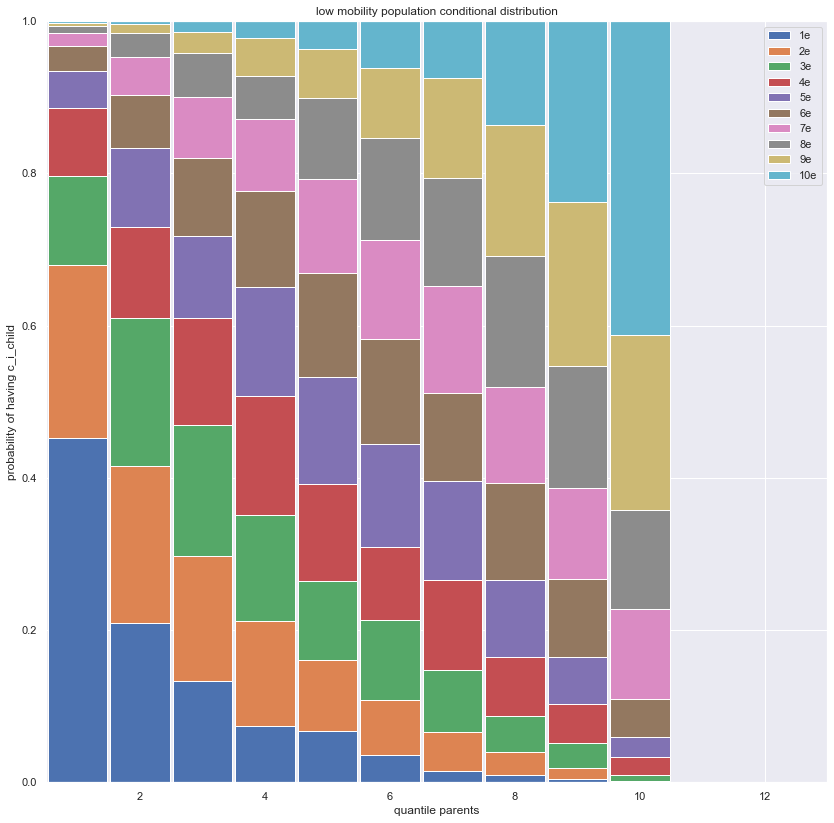

In [89]:
plt.figure(figsize=(14,14))
    
cumul = np.array([0] * nb_quantiles) 
    
for i, child_quantile in enumerate(cd):
    plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
    cumul = cumul + np.array(child_quantile)

plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
plt.title("low mobility population conditional distribution")
plt.legend()
plt.xlabel("quantile parents")
plt.ylabel("probability of having c_i_child") 
plt.show()

# As we can see from this graph, in low mobility populations, the lower class is more disadvantaged while the upper
# class is at an advantage.

# The likelihood of someone in the lower class (on the left) reaching a higher income bracket is very low. 
# While the higher income classes (on the right) are more likely to stay rich. 

In [90]:
# Testing probability for different parent and child classes
c_i_child = 5 
c_i_parent = 8
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))


P(c_i_parent = 8 | c_i_child = 5, pj = 0.9) = 0.102


#### High mobility population conditional distribution

In [91]:
nb_quantiles = 10
n  = 1000*nb_quantiles
pj = 0.1

In [92]:
(y_child, y_parents) = generate_incomes(n, pj)

In [93]:
sample = compute_quantiles(y_child, y_parents, nb_quantiles)

In [94]:
cd = conditional_distributions(sample, nb_quantiles)

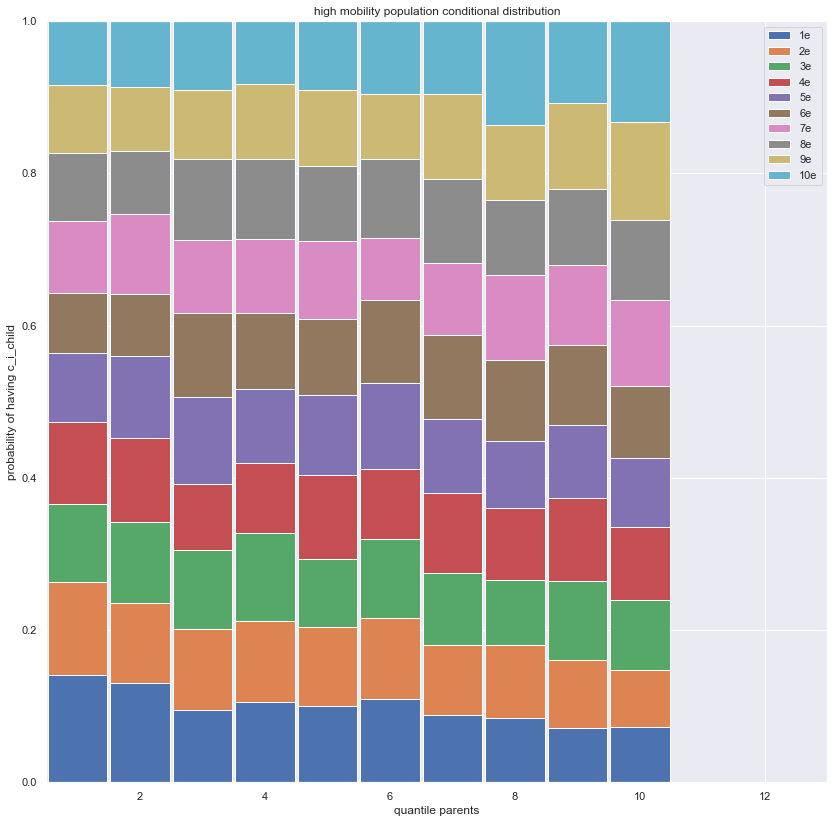

In [95]:
plt.figure(figsize=(14,14))
    
cumul = np.array([0] * nb_quantiles) 
    
for i, child_quantile in enumerate(cd):
    plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
    cumul = cumul + np.array(child_quantile)

plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
plt.title("high mobility population conditional distribution")
plt.legend()
plt.xlabel("quantile parents")
plt.ylabel("probability of having c_i_child") 
plt.show()

# This graph looks different compared to the low-mobility population graph. 
# That's because in high mobility populations, it's easier to move between social classes. 

In [96]:
# Testing probability for different parent and child classes
c_i_child = 5 
c_i_parent = 8
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))


P(c_i_parent = 8 | c_i_child = 5, pj = 0.1) = 0.105


### Creating a new sample

* To avoid confusion, the individuals generated can be deleted and the conditional distributions kept.

* Next is applying a new sample used with the World Income Distribution. For each individual from WID, 499 clones will be created. Then the size of the sample will be 500 times larger than the initial WID sample.

* For each c_i_child and each country, there would then be 500 individuals. The 500 individuals need to be assigned to their c_i_parent classes, following the previously found distributions. 

Next is renaming the columns to match the protocol. 

* quantile = c_i_child

* income = y_child

* IGEincome = pj

* mean_income = mj

* Gini Index = Gj

In [97]:
df_edited.rename(columns = {'Gini Index': 'gj', 'base_case': 'base_case', 'income': 'y_child', 'quantile': 'c_i_child', 'mean_income': 'mj'}, inplace=True)



In [98]:
df_edited.head(1)

,gj,Total_Population,base_case,countryname,gdpppp,y_child,nb_quantiles,opti_case,pess_case,c_i_child,mj
0,30.0,2947314.0,0.4,Albania,7297.0,728.89795,100.0,0.3,0.5,1,2994.829902


In [99]:
# Then adding 500 clones for each individual in the WID sample
df_cloned = pd.concat([df_edited]*500)

In [100]:
df_cloned.head(1)

,gj,Total_Population,base_case,countryname,gdpppp,y_child,nb_quantiles,opti_case,pess_case,c_i_child,mj
0,30.0,2947314.0,0.4,Albania,7297.0,728.89795,100.0,0.3,0.5,1,2994.829902


In [101]:
df_cloned.sort_values(by=['countryname', 'c_i_child'], inplace=True)

In [102]:
# df_cloned needs to match this format while retaining the country names
# region, incgroup4, total_population, nb_quantiles, Gini_Index, gdpppp need to be dropped
# In the protocol, it said y_parents could be dropped. 
sample.head(3)

,y_child,y_parents,c_i_child,c_i_parent
0,0.763299,1.528950,4,7
1,0.354140,0.357206,2,2
2,2.148701,4.365243,8,10


In [103]:
sample_dff = df_cloned[['countryname', 'c_i_child', 'y_child', 'base_case', 'gj', 'mj']]

In [104]:
sample_dff.head(3)

,countryname,c_i_child,y_child,base_case,gj,mj
0,Albania,1,728.89795,0.4,30.0,2994.829902
0,Albania,1,728.89795,0.4,30.0,2994.829902
0,Albania,1,728.89795,0.4,30.0,2994.829902


In [105]:
sample_df = sample_dff.reset_index(drop=True)

In [106]:
sample_df.shape

(5800000, 6)

In [107]:
sample_df.head(3)

,countryname,c_i_child,y_child,base_case,gj,mj
0,Albania,1,728.89795,0.4,30.0,2994.829902
1,Albania,1,728.89795,0.4,30.0,2994.829902
2,Albania,1,728.89795,0.4,30.0,2994.829902


In [108]:
sample_df.info()

# all the important columns for the next section have the same datatype of float64
# if it's still working and the dtypes are different, may be sign of a problem

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5800000 entries, 0 to 5799999
Data columns (total 6 columns):
countryname    object
c_i_child      int64
y_child        float64
base_case      float64
gj             float64
mj             float64
dtypes: float64(4), int64(1), object(1)
memory usage: 265.5+ MB


### Computing the elasticity dictionary

From "Measuring Intergenerational Income Mobility" 
https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-analyst/2011-measuring-intergenerational-income-mobility-art.pdf -->

"Roughly speaking, the value of elasticity (ß1) represents the fraction of income that is on average transmitted across generations. In general, empirical estimates of ß1 tend to lie between 0 and 1. For example, ß1 = 0.4 indicates that 40 percent of the parental income position is transmitted to the next generation. A value of zero for ß1 represents a case of complete mobility where the incomes of parents and children are completely unrelated."

In [109]:
# What are the unique base values for the elasticity coefficients? 
coefficients = elasticity['base_case'].unique()
coefficients

array([0.66, 0.5 , 0.4 , 0.2 ])

In [110]:
# Making a list out of the unique values
# base_case is the same as pj
pj = [0.66, 0.5 , 0.4 , 0.2 ]
pj

[0.66, 0.5, 0.4, 0.2]

In [111]:
# Creating the dictionary with conditional distributions matched to every possible example of a base case

nb_quantiles = 100
n = 1000 * nb_quantiles
dict_elasticity = {}

def class_parent(pj):
    for x in pj:
        y_child, y_parents = generate_incomes(n, x)
        sample = compute_quantiles(y_child, y_parents, nb_quantiles)
        cd = conditional_distributions(sample, nb_quantiles)
        dict_elasticity = {x:cd for x in pj}
        return dict_elasticity

dict_elasticity = class_parent(pj)
dict_elasticity

{0.66: array([[0.159, 0.096, 0.079, ..., 0.   , 0.   , 0.   ],
        [0.11 , 0.062, 0.054, ..., 0.   , 0.   , 0.   ],
        [0.069, 0.043, 0.047, ..., 0.   , 0.   , 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.054, 0.056, 0.059],
        [0.   , 0.   , 0.   , ..., 0.049, 0.061, 0.085],
        [0.   , 0.   , 0.   , ..., 0.054, 0.083, 0.15 ]]),
 0.5: array([[0.159, 0.096, 0.079, ..., 0.   , 0.   , 0.   ],
        [0.11 , 0.062, 0.054, ..., 0.   , 0.   , 0.   ],
        [0.069, 0.043, 0.047, ..., 0.   , 0.   , 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.054, 0.056, 0.059],
        [0.   , 0.   , 0.   , ..., 0.049, 0.061, 0.085],
        [0.   , 0.   , 0.   , ..., 0.054, 0.083, 0.15 ]]),
 0.4: array([[0.159, 0.096, 0.079, ..., 0.   , 0.   , 0.   ],
        [0.11 , 0.062, 0.054, ..., 0.   , 0.   , 0.   ],
        [0.069, 0.043, 0.047, ..., 0.   , 0.   , 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.054, 0.056, 0.059],
        [0.   , 0.   , 0.   ,

In [112]:
dict_elasticity[0.2].shape

(100, 100)

### Creating the Parent Class

I need to go through each row of sample_df to compute the parent class. 

In each, I need to: 

1. Make a subset of the data while debugging it

1. pick a random value based on the dict_elasticity (weighted probability), using random.choice() You can use .apply, itertuples, iterrows, etc.

2. I should take a subset of the data — 1,000 rows for debugging the code 

3. May use parallel processing libraries to speed up the code

In [113]:
# the dataset
sample_df.head(3)

,countryname,c_i_child,y_child,base_case,gj,mj
0,Albania,1,728.89795,0.4,30.0,2994.829902
1,Albania,1,728.89795,0.4,30.0,2994.829902
2,Albania,1,728.89795,0.4,30.0,2994.829902


In [114]:
# making a subsample
subsample_df = sample_df.sample(n=1000)
subsample_df.head(3)

,countryname,c_i_child,y_child,base_case,gj,mj
3448906,Mauritania,98,6133.9830,0.66,35.7,1798.609083
238195,Azerbaijan,77,2884.8845,0.50,30.4,2357.429023
4973708,Sweden,48,14236.1020,0.20,28.1,16184.222707


In [116]:
subsample_df.base_case.unique()

array([0.66, 0.5 , 0.2 , 0.4 ])

In [117]:
# creating the function to be applied to the subsample

def random_class(base_case, c_i_child):
#     returning a single value [1-100] drawn randomly, 
#     weighted on the elasticity dictionary distribution
    return np.random.choice(range(1,101), p=dict_elasticity[base_case][c_i_child-1])

In [118]:
# applying the function that will create the parent class to the subsample
subsample_df['c_i_parent'] = subsample_df.apply(lambda x: random_class(x.base_case, x.c_i_child), axis=1 )

In [119]:
subsample_df

,countryname,c_i_child,y_child,base_case,gj,mj,c_i_parent
3448906,Mauritania,98,6133.98300,0.66,35.7,1798.609083,94
238195,Azerbaijan,77,2884.88450,0.50,30.4,2357.429023,81
4973708,Sweden,48,14236.10200,0.20,28.1,16184.222707,95
2075172,Guatemala,51,1187.39000,0.66,33.6,2142.474753,73
864809,Central African Republic,30,279.92484,0.66,56.2,811.299901,80
...,...,...,...,...,...,...,...
2295415,Iceland,91,42450.72700,0.20,31.8,26888.511518,35
3329179,Malaysia,59,4876.52340,0.50,45.5,6006.342359,49
591299,Brazil,83,6685.88530,0.66,54.0,4807.484594,95
1092063,Costa Rica,85,8725.43200,0.66,48.7,5580.386556,48


In [120]:
# applying the function to the entire df 
# this section is commented-out just because it takes quite a bit of time to run the function 
def random_class(base_case, c_i_child):
#     '''return a single value [1-100] drawn randomly, 
#     weighted on the elasticity dictionary distribution'''
   return np.random.choice(range(1,101), p=dict_elasticity[base_case][c_i_child-1])

In [121]:
sample_df['c_i_parent'] = sample_df.apply(lambda x: random_class(x.base_case, x.c_i_child), axis=1 )

In [122]:
sample_df

,countryname,c_i_child,y_child,base_case,gj,mj,c_i_parent
0,Albania,1,728.89795,0.4,30.0,2994.829902,2
1,Albania,1,728.89795,0.4,30.0,2994.829902,3
2,Albania,1,728.89795,0.4,30.0,2994.829902,7
3,Albania,1,728.89795,0.4,30.0,2994.829902,7
4,Albania,1,728.89795,0.4,30.0,2994.829902,65
...,...,...,...,...,...,...,...
5799995,Yemen,100,9050.43750,0.5,35.0,1042.635870,84
5799996,Yemen,100,9050.43750,0.5,35.0,1042.635870,97
5799997,Yemen,100,9050.43750,0.5,35.0,1042.635870,79
5799998,Yemen,100,9050.43750,0.5,35.0,1042.635870,93


In [123]:
sample_df.columns

Index(['countryname', 'c_i_child', 'y_child', 'base_case', 'gj', 'mj',
       'c_i_parent'],
      dtype='object')

In [124]:
quantile_one = sample_df.loc[sample_df.c_i_child == 1]

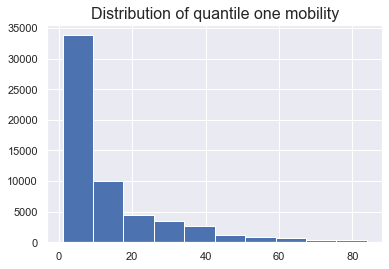

In [125]:
plt.hist(quantile_one.c_i_parent)
plt.title('Distribution of quantile one mobility', fontsize = 16)
plt.show()

In [126]:
quantile_fifty = sample_df.loc[sample_df.c_i_parent == 50]

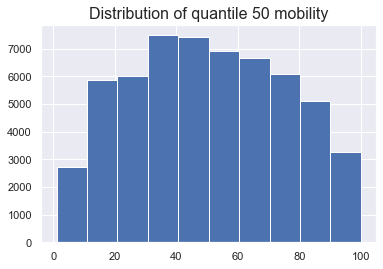

In [127]:
plt.hist(quantile_fifty.c_i_child)
plt.title('Distribution of quantile 50 mobility', fontsize = 16)
plt.show()

In [128]:
quantile_hundred = sample_df.loc[sample_df.c_i_parent == 100]

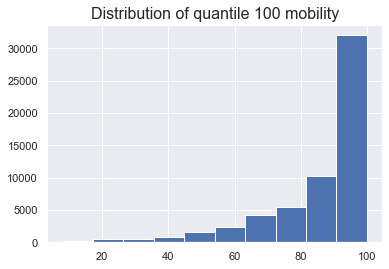

In [129]:
plt.hist(quantile_hundred.c_i_child)
plt.title('Distribution of quantile 100 mobility', fontsize = 16)
plt.show()

In [130]:
sample_df.drop(columns='c_i_child', inplace=True)

In [131]:
sample_df.to_csv(r'/Users/larabockenstedt/Making_an_Income_Prediction/sample.csv', index=False)

In [132]:
sample_df = pd.read_csv('sample.csv')
sample_df.head()

,countryname,y_child,base_case,gj,mj,c_i_parent
0,Albania,728.89795,0.4,30.0,2994.829902,2
1,Albania,728.89795,0.4,30.0,2994.829902,3
2,Albania,728.89795,0.4,30.0,2994.829902,7
3,Albania,728.89795,0.4,30.0,2994.829902,7
4,Albania,728.89795,0.4,30.0,2994.829902,65
